In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
def count_true(a1, a2):
  e = torch.eq(a1, a2)
  e = e.cpu().numpy()
  c = np.count_nonzero(e)
  return c

In [5]:
def preprocess():
   # load the text file
    data = open("dataset.txt", 'r').read()
    chars = sorted(list(set(data)))
    data_size, vocab_size = len(data), len(chars)
    
    # char to index and index to char maps
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    ix_to_char = { i:ch for i,ch in enumerate(chars) }
    
    # convert data from chars to indices
    data = list(data)
    for i, ch in enumerate(data):
        data[i] = char_to_ix[ch]
    # data tensor on device
    data = torch.tensor(data).to(device)
    data = torch.unsqueeze(data, dim=1)
    
    return data , ix_to_char , data_size, vocab_size

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.fc(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())

In [7]:
def test(data,data_size,rnn,ix_to_char):

        data_ptr = 0
        hidden_state = None
        # random character
        rand_index = np.random.randint(data_size-1)
        input_seq = data[rand_index : rand_index+1]
        
        for i in range(400):
          
            # forward pass
            output, hidden_state = rnn(input_seq, hidden_state)
            
            # construct categorical distribution and sample a character
            output = F.softmax(torch.squeeze(output), dim=0)
            dist = Categorical(output)
            index = dist.sample()
            
            # print the sampled character
            print(ix_to_char[index.item()], end='')
            
            # next input is current output
            input_seq[0][0] = index.item()
            data_ptr += 1
            
            

In [8]:
def train(data , ix_to_char, data_size, vocab_size,rnn,epochs,seq_len,loss_fn,optimizer):
    acc = []
    loss_list = []
    for i_epoch in range(1, epochs+1):
        
        # random starting point (1st 100 chars) from data to begin
        data_ptr = np.random.randint(100)
        n = 0
        running_loss = 0
        hidden_state = None
        true_predicts = 0
         
        while True:
            input_seq = data[data_ptr : data_ptr+seq_len]
            target_seq = data[data_ptr+1 : data_ptr+seq_len+1]
            # forward pass
            output, hidden_state = rnn(input_seq, hidden_state)
            # compute loss
            loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
            running_loss += loss.item()
            output = F.softmax(torch.squeeze(output), dim=0)
            dist = Categorical(output)
            index = dist.sample()
            # compute gradients and take optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # compute true predicts
            true_predicts += count_true(torch.squeeze( target_seq), index)
            
            # update the data pointer
            data_ptr += seq_len
            n +=1
            
            # if at end of data : break
            if data_ptr + seq_len + 1 > data_size:
                break
        acc.append(true_predicts*100/data_size)  
        loss_list.append(running_loss/n)  
        # print loss
        print("Epoch: {0} \t Loss: {1:.4f} \t accuracy: {2:.4f}".format(i_epoch, running_loss/n,true_predicts*100/data_size))

    return acc,loss_list


In [9]:
def runn(hidden_size, seq_len, num_layers, lr, epochs):
  # Hyperparameters
  hidden_size = hidden_size  
  # length of LSTM sequence 
  seq_len = seq_len
  # num of layers in LSTM layer stack      
  num_layers =num_layers      
  lr = lr   
  epochs = epochs
  data , ix_to_char, data_size, vocab_size =  preprocess()
  # model 
  rnn = RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
  # loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

  acc_list,loss_list = train(data , ix_to_char, data_size, vocab_size,rnn,epochs,seq_len,loss_fn,optimizer)
  print("generate text ------------------------------")
  test(data,data_size,rnn,ix_to_char)
  return acc_list,loss_list

In [10]:
acc_list,loss_list = runn(512, 250, 3, 0.001, 40)

Epoch: 1 	 Loss: 1.5872 	 accuracy: 16.7015
Epoch: 2 	 Loss: 1.2128 	 accuracy: 25.3232
Epoch: 3 	 Loss: 1.1147 	 accuracy: 29.0026
Epoch: 4 	 Loss: 1.0556 	 accuracy: 30.8646
Epoch: 5 	 Loss: 1.0132 	 accuracy: 32.6686
Epoch: 6 	 Loss: 0.9789 	 accuracy: 33.8316
Epoch: 7 	 Loss: 0.9517 	 accuracy: 34.8626
Epoch: 8 	 Loss: 0.9290 	 accuracy: 35.4431
Epoch: 9 	 Loss: 0.9116 	 accuracy: 36.1078
Epoch: 10 	 Loss: 0.8947 	 accuracy: 36.5875
Epoch: 11 	 Loss: 0.8816 	 accuracy: 37.0055
Epoch: 12 	 Loss: 0.8706 	 accuracy: 37.5286
Epoch: 13 	 Loss: 0.8610 	 accuracy: 37.7655
Epoch: 14 	 Loss: 0.8528 	 accuracy: 38.5033
Epoch: 15 	 Loss: 0.8450 	 accuracy: 38.7030
Epoch: 16 	 Loss: 0.8397 	 accuracy: 38.9765
Epoch: 17 	 Loss: 0.8345 	 accuracy: 39.5887
Epoch: 18 	 Loss: 0.8318 	 accuracy: 39.8738
Epoch: 19 	 Loss: 0.8285 	 accuracy: 39.9702
Epoch: 20 	 Loss: 0.8279 	 accuracy: 40.3054
Epoch: 21 	 Loss: 0.8253 	 accuracy: 40.5835
Epoch: 22 	 Loss: 0.8237 	 accuracy: 40.7137
Epoch: 23 	 Loss: 0

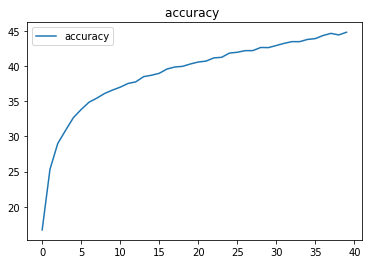

In [11]:
import matplotlib.pyplot as plt
plt.plot(acc_list,label="accuracy")
plt.legend()
plt.title("accuracy ")
plt.show()

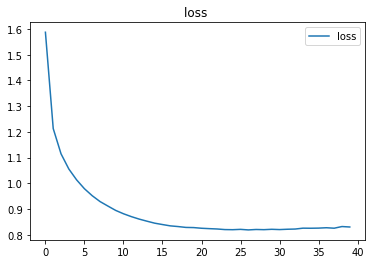

In [12]:
plt.plot(loss_list,label="loss")
plt.legend()
plt.title("loss ")
plt.show()